In [11]:
!pip install duckdb ydata-profiling pycaret  xgboost lightgbm catboost

^C


In [1]:
%load_ext autoreload

In [1]:
%autoreload 2

UsageError: Line magic function `%autoreload` not found.


In [2]:
import pandas as pd
import numpy as np
import duckdb
import plotnine as p9

import pandas as pd
from sklearn.preprocessing import KBinsDiscretizer
from kmodes.kmodes import KModes

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from kmodes.kprototypes import KPrototypes
from sklearn.metrics import adjusted_rand_score


In [9]:
train_data = pd.read_parquet("X_train_imputed.parquet")
test_data = pd.read_parquet("X_test_imputed.parquet")

In [10]:

 train_data['target']

0          3.457882
1          3.171434
2          2.754348
3          2.884229
4          3.305996
             ...   
1199995    3.115278
1199996    2.914872
1199997    2.570543
1199998    2.775974
1199999    3.394627
Name: target, Length: 1200000, dtype: float64

In [11]:
train_data['target'] = np.power(10, train_data['target']) - 1
#test_data['target'] = np.power(10, test_data['target']) - 1

In [12]:
train_data['target']

0          2869.0
1          1483.0
2           567.0
3           765.0
4          2022.0
            ...  
1199995    1303.0
1199996     821.0
1199997     371.0
1199998     596.0
1199999    2480.0
Name: target, Length: 1200000, dtype: float64

<Axes: ylabel='Frequency'>

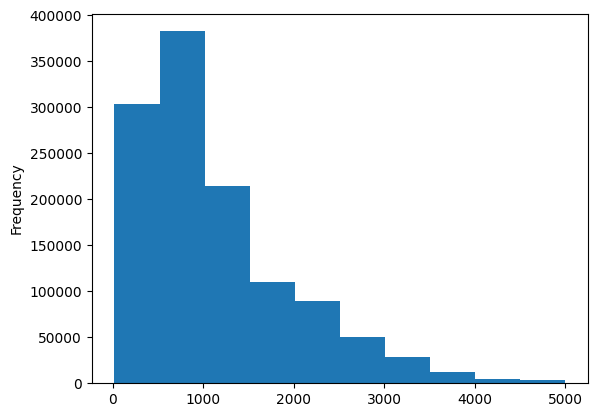

In [14]:
train_data['target'].plot.hist()

<Axes: ylabel='Frequency'>

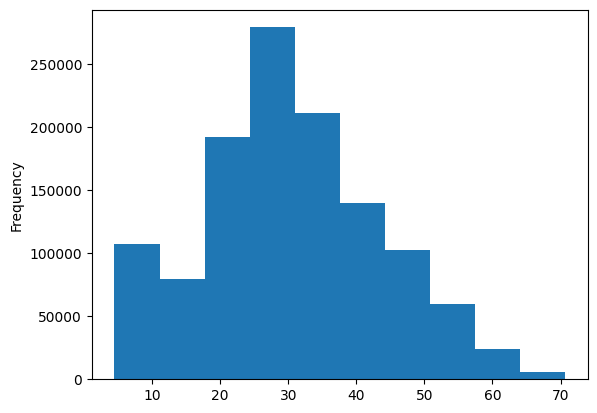

In [16]:
np.sqrt(train_data['target']).plot.hist()

<Axes: ylabel='Frequency'>

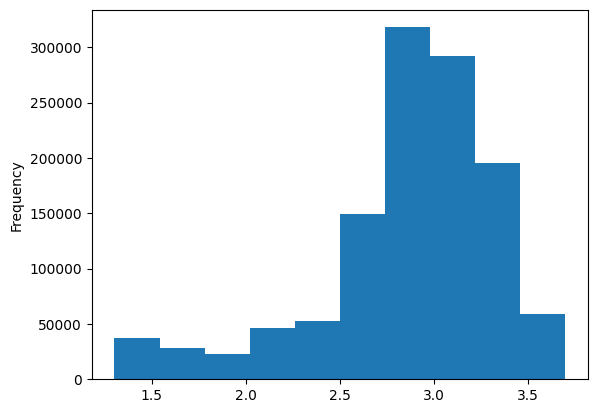

In [17]:
np.log10(train_data['target']).plot.hist()


In [41]:
X_train = train_data[[col for col in train_data.columns if col not in ['id','Policy Start Date','target']]]
X_test = test_data[[col for col in test_data.columns if col not in ['id','Policy Start Date','target']]]

y_train = np.log10(train_data['target'])

In [67]:
# Separate numeric and categorical columns
numeric_cols_post_treat = X_train.select_dtypes(include=['float64', 'int64', 'bool']).columns
categorical_cols_post_treat = X_train.select_dtypes(include=['object','bool',"category"]).columns

In [75]:
spearman_corr = train_data[list(numeric_cols_post_treat) + ['target']].corr(method='spearman')['target']


In [78]:
monotone_constraints = {
    "Age": 0,  # Correlation close to zero (-0.002287); no clear monotonic relationship.
    "Annual Income": -1,  # Negative correlation (-0.059330); higher income → lower premium.
    "Number of Dependents": 0,  # Correlation close to zero (-0.001644); no clear monotonic relationship.
    "Health Score": 1,  # Positive correlation (0.015903); better health → higher premium.
    "Previous Claims": 1,  # Positive correlation (0.032637); more claims → higher premium.
    "Vehicle Age": 0,  # Correlation close to zero (0.000866); no clear monotonic relationship.
    "Credit Score": -1,  # Negative correlation (-0.031246); higher credit → lower premium.
    "Insurance Duration": 0,  # Correlation close to zero (-0.000071); no clear monotonic relationship.
    "Customer Tenure": 1,  # Positive correlation (0.010183); longer tenure → higher premium.
    "Claim Frequency": 1,  # Positive correlation (0.023029); higher frequency → higher premium.
    "Null columns": -1,  # Negative correlation (-0.014488); more nulls → lower premium.
    "Annual Income log 10": -1,  # Mirrors "Annual Income" (-0.059358); higher log income → lower premium.
    "Previous Claims log": 1,  # Mirrors "Previous Claims" (0.031878); more claims → higher premium.
    "Age_null": 0,  # Correlation close to zero (-0.000847); no clear monotonic relationship.
    "Gender_null": 0,  # Correlation is NaN; no clear monotonic relationship.
    "Annual Income_null": -1,  # Negative correlation (-0.065399); missing income → lower premium.
    "Marital Status_null": 1,  # Positive correlation (0.017521); missing marital status → higher premium.
    "Number of Dependents_null": 1,  # Positive correlation (0.006702); missing dependents → higher premium.
    "Education Level_null": 0,  # Correlation is NaN; no clear monotonic relationship.
    "Occupation_null": 0,  # Correlation close to zero (-0.006567); no clear monotonic relationship.
    "Health Score_null": 1,  # Positive correlation (0.033795); missing health score → higher premium.
    "Location_null": 0,  # Correlation is NaN; no clear monotonic relationship.
    "Policy Type_null": 0,  # Correlation is NaN; no clear monotonic relationship.
    "Previous Claims_null": -1,  # Negative correlation (-0.019464); missing claims → lower premium.
    "Vehicle Age_null": 0,  # Correlation close to zero (0.000323); no clear monotonic relationship.
    "Credit Score_null": -1,  # Negative correlation (-0.011197); missing credit score → lower premium.
    "Insurance Duration_null": 0,  # Correlation close to zero (0.000273); no clear monotonic relationship.
    "Customer Feedback_null": 1,  # Positive correlation (0.029329); missing feedback → higher premium.
    "Smoking Status_null": 0,  # Correlation is NaN; no clear monotonic relationship.
    "Exercise Frequency_null": 0,  # Correlation is NaN; no clear monotonic relationship.
    "Property Type_null": 0,  # Correlation is NaN; no clear monotonic relationship.
    "Customer Tenure_null": 0,  # Correlation is NaN; no clear monotonic relationship.
    "Claim Frequency_null": -1,  # Negative correlation (-0.019463); fewer claims → lower premium.
    "Policy Start Year_null": 0,  # Correlation is NaN; no clear monotonic relationship.
    "Policy Start Month_null": 0,  # Correlation is NaN; no clear monotonic relationship.
    "Policy Start Day_null": 0,  # Correlation is NaN; no clear monotonic relationship.
    "Policy Start Hour_null": 0,  # Correlation is NaN; no clear monotonic relationship.
    "Policy Start Minute_null": 0,  # Correlation is NaN; no clear monotonic relationship.
    "Policy Start Second_null": 0,  # Correlation is NaN; no clear monotonic relationship.
    "Null columns_null": 0,  # Correlation is NaN; no clear monotonic relationship.
    "Annual Income log 10_null": -1,  # Mirrors "Annual Income_null" (-0.065399).
    "Previous Claims log_null": -1,  # Mirrors "Previous Claims_null" (-0.019464).
    "rand_var_0": 0,  # Correlation close to zero (0.001132); no clear monotonic relationship.
    "rand_var_1": 0,  # Correlation close to zero (0.001108); no clear monotonic relationship.
    "rand_var_2": 0,  # Correlation close to zero (-0.000639); no clear monotonic relationship.
    "rand_var_3": 0,  # Correlation close to zero (0.001530); no clear monotonic relationship.
    "rand_var_4": 0,  # Correlation close to zero (0.001034); no clear monotonic relationship.
    "rand_var_5": 0,  # Correlation close to zero (-0.000231); no clear monotonic relationship.
    "rand_var_6": 0,  # Correlation close to zero (0.000430); no clear monotonic relationship.
    "rand_var_7": 0,  # Correlation close to zero (0.001516); no clear monotonic relationship.
    "rand_var_8": 0,  # Correlation close to zero (0.000923); no clear monotonic relationship.
    "rand_var_9": 0,  # Correlation close to zero (0.000560); no clear monotonic relationship.
}


<Axes: >

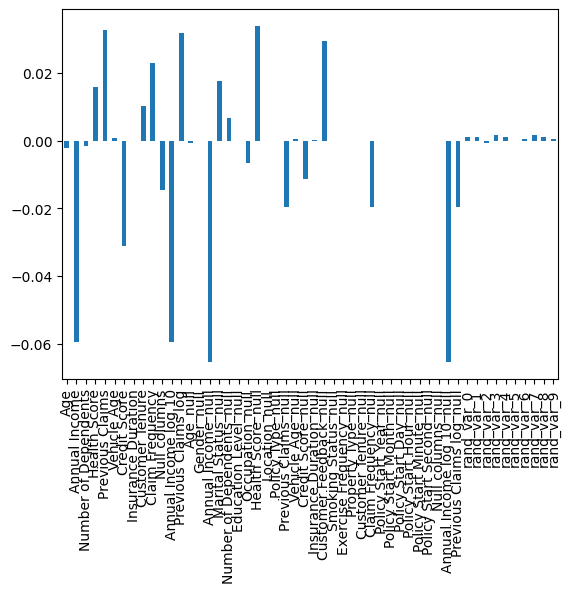

In [76]:
spearman_corr.iloc[:-1].plot.bar()

# Lighbm

In [79]:
from sklearn.metrics import root_mean_squared_log_error

In [80]:
def rmsle_objective(y_pred, dataset):
    y_true = dataset.get_label()
    
    y_true = np.power(10, y_true)
    y_pred = np.power(10, y_pred)
    
    # Ensure no negative predictions
    y_pred = np.maximum(y_pred, 1e-15)
    log_diff = np.log(y_pred + 1) - np.log(y_true + 1)
    grad = 2 * log_diff / (y_pred + 1)
    hess = 2 / (y_pred + 1)**2
    
    return grad, hess

def rmsle_metric(y_pred, y_true):    
    y_true = np.power(10, y_true) - 1
    y_pred = np.power(10, y_pred) - 1

    rmsle = root_mean_squared_log_error(y_true, y_pred)
    
    return 'rmsle', rmsle, False  # False because lower is better

In [81]:
import lightgbm as lgb
import numpy as np
from sklearn.model_selection import KFold


In [82]:
import xgboost as xgb
import lightgbm as lgb


In [85]:
from sklearn.model_selection import ShuffleSplit
import numpy as np

# Define a 60-40 splitzzz
splitter = ShuffleSplit(n_splits=5, test_size=0.2, random_state=1)

for train_idx, val_idx in splitter.split(X_train):
    print("Starting")
    # Prepare data for LightGBM
    X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    # Train model
    model = xgb.XGBRegressor(enable_categorical=True, learning_rate=0.1, n_estimators=500,tree_method="hist", max_bin=256)
    model.fit(X_train_fold, y_train_fold)
    
    train_score = rmsle_metric(model.predict(X_train_fold), y_train_fold)
    val_score = rmsle_metric(model.predict(X_val_fold), y_val_fold)

    print(f"Train: {train_score}, Test: {val_score}")

Starting
Train: ('rmsle', 1.0287867196565978, False), Test: ('rmsle', 1.0519102453442641, False)
Starting
Train: ('rmsle', 1.027867507688628, False), Test: ('rmsle', 1.053749619776246, False)
Starting
Train: ('rmsle', 1.0282426572526795, False), Test: ('rmsle', 1.0528823242286733, False)
Starting
Train: ('rmsle', 1.028107395676486, False), Test: ('rmsle', 1.0540931514630545, False)
Starting
Train: ('rmsle', 1.0291732557928999, False), Test: ('rmsle', 1.0514345985517837, False)


In [48]:

model.get_booster().get_score(importance_type='total_gain')

{'Age': 320.4644775390625,
 'Gender': 17.5758113861084,
 'Annual Income': 3469.93115234375,
 'Marital Status': 58.2567138671875,
 'Number of Dependents': 55.974937438964844,
 'Education Level': 92.24388122558594,
 'Occupation': 45.447322845458984,
 'Health Score': 9887.55859375,
 'Location': 59.787498474121094,
 'Policy Type': 56.43910598754883,
 'Previous Claims': 9440.345703125,
 'Vehicle Age': 191.5749053955078,
 'Credit Score': 21389.412109375,
 'Insurance Duration': 95.7105941772461,
 'Customer Feedback': 67.8544692993164,
 'Smoking Status': 16.720108032226562,
 'Exercise Frequency': 112.70941162109375,
 'Property Type': 61.54753875732422,
 'Customer Tenure': 1327.20751953125,
 'Claim Frequency': 239.33746337890625,
 'Policy Start Year': 4972.564453125,
 'Policy Start Month': 133.5119171142578,
 'Policy Start Day': 212.60574340820312,
 'Null columns': 117.30823516845703,
 'Annual Income log 10': 17166.2109375,
 'Previous Claims log': 2472.15576171875,
 'Age_null': 27.9086666107177

In [63]:
importances = pd.Series(model.get_booster().get_score(importance_type='total_gain')).reset_index()
importances.columns = ["column", "gain"]
importances["rand_var"] = importances["column"].str.contains("rand_var")

importances["better_than_probe_avg"] = (importances["gain"] > importances.loc[importances["rand_var"], "gain"].mean()) & ~importances["rand_var"]
importances =importances.sort_values(by="gain")
usable_columns = list(importances[importances["better_than_probe_avg"]]["column"].values)

# LightGBM Limited Features

In [64]:
X_train_fixed = X_train.loc[:, usable_columns]

In [65]:
usable_columns

[]

In [218]:
from sklearn.model_selection import ShuffleSplit
import numpy as np

# Define a 60-40 split
splitter = ShuffleSplit(n_splits=5, test_size=0.2, random_state=1)

for train_idx, val_idx in splitter.split(X_train):
    print("Starting")
    # Prepare data for LightGBM
    X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    # Train model
    model = xgb.XGBRegressor(enable_categorical=True, eta=0.1
                             , colsample_bytree=1.0, num_boost_round=5000)
    model.fit(X_train_fold, y_train_fold)
    
    train_score = rmsle_metric(model.predict(X_train_fold), y_train_fold)
    val_score = rmsle_metric(model.predict(X_val_fold), y_val_fold)

    print(f"Train: {train_score}, Test: {val_score}")

Starting
Train: ('rmsle', 1.0414319480241936, False), Test: ('rmsle', 1.0443248048531553, False)
Starting
Train: ('rmsle', 1.0409693537040736, False), Test: ('rmsle', 1.0461658721352969, False)
Starting
Train: ('rmsle', 1.04124619189709, False), Test: ('rmsle', 1.0447801409767128, False)
Starting
Train: ('rmsle', 1.0410541920096403, False), Test: ('rmsle', 1.0460724699143016, False)
Starting
Train: ('rmsle', 1.0416228339266616, False), Test: ('rmsle', 1.0436687891507819, False)


In [219]:
importances = pd.Series(model.get_booster().get_score(importance_type='total_gain')).reset_index()
importances.columns = ["column", "gain"]
importances["rand_var"] = importances["column"].str.contains("rand_var")

importances["better_than_probe_avg"] = (importances["gain"] > importances.loc[importances["rand_var"], "gain"].mean()) & ~importances["rand_var"]
importances =importances.sort_values(by="gain")
usable_columns = list(importances[importances["better_than_probe_avg"]]["column"].values)

In [220]:
importances

,column,gain,rand_var,better_than_probe_avg
15,Smoking Status,13.097382,False,False
1,Gender,15.256684,False,False
17,Property Type,38.792526,False,False
9,Policy Type,60.558346,False,False
14,Customer Feedback,72.182533,False,False
3,Marital Status,82.241837,False,False
6,Occupation,84.737862,False,False
5,Education Level,88.832588,False,False
25,Occupation_null,91.203659,False,False
8,Location,95.033760,False,False


In [221]:
from statsmodels.distributions.empirical_distribution import ECDF
import matplotlib.pyplot as plt

def rescale(series, from_min, from_max, to_min, to_max):
    return to_min + ((series - from_min) * (to_max - to_min)) / (from_max - from_min)

In [223]:
model = model.fit(X_train, y_train)

In [225]:
model.save_model("results_201224_1828_limited_columns.pkl")

In [226]:
y_train_pred = model.predict(X_train)#.loc[:, usable_columns])
y_val_pred = model.predict(X_val)#.loc[:, usable_columns])


In [227]:
res_Data = full_test_csv_data[["id"]].copy()

In [228]:
res_Data["pred"] = np.power(10, y_val_pred) - 1

In [229]:
res_Data.columns = ["id","Premium Amount"]

In [230]:
res_Data.to_csv("results_201224_1828_limited_columns.csv",index=False,header=True)